In [1]:
import tensorflow as tf
import numpy as np
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [2]:
tfm = tfp.models

In [3]:
# Generate synthetic data
inputs = np.arange(2,20,0.2)
outputs = 0.1*np.square(inputs) + 8*np.sin(2*inputs/3) + 0.5*np.random.randn(len(inputs))

test_inputs = np.array([3.4,7.7, 8.5, 11.6, 13.7, 15.1, 19.3])

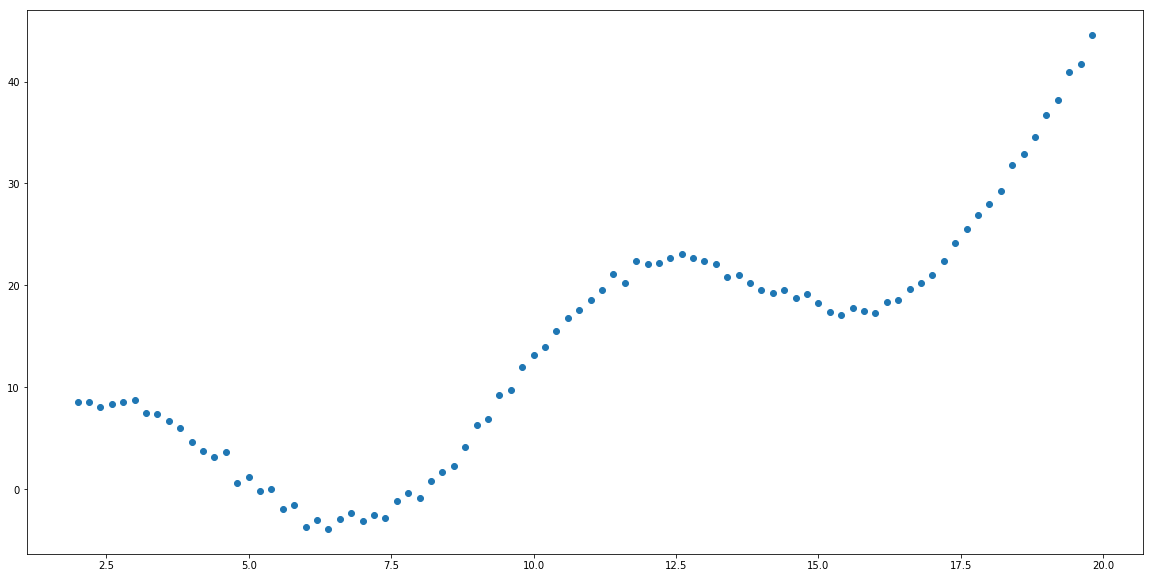

In [4]:
plt.figure(figsize =(20,10))
plt.scatter(inputs,outputs)

In [5]:
labels = ['x']

In [6]:
# Normalizing the outputs 
mean = np.mean(outputs)
std = np.std(outputs)
outputsnorm = (outputs - mean)/std

In [7]:
# normalizing the inputs
mean_x = np.mean(inputs, axis = 0)
std_x = np.std(inputs, axis = 0, keepdims = True)

inputsnorm = (inputs - mean_x)/std_x
test_inputsnorm = (test_inputs - mean_x)/std_x

scaling_inp = [mean_x, std_x]

In [8]:
model = tfm.BayesianGP(inputsnorm, outputsnorm, 'RBF', 1e-3)


In [9]:
n_inputs = 1

In [10]:
# Initializing the hyperparameters
beta = 1.5*tf.ones(n_inputs, tf.float32)
varm = 0.8
loc = 0.0


initial_state = [beta, varm, loc]

In [11]:
mcmc_samples = 4000
burn_in = 3000
num_leapfrog_steps = 3
num_warmup_iter = burn_in
step_size, beta_next, varm_next, loc_next = model.warmup(initial_state,num_warmup_iter, num_leapfrog_steps)
print(step_size)

Warmup: 
Step  0
Step  500
Step  1000
Step  1500
Step  2000
Step  2500
Time per step in warm up:  0.004624000946680705
0.174494


In [12]:
initial_state = [beta_next, varm_next, loc_next]

In [13]:
loc_probs_, varm_probs_, beta_probs_, acceptance_rate_ = model.mcmc(mcmc_samples, burn_in, initial_state,0.9*step_size, num_leapfrog_steps)

W0206 22:46:05.935607 139828520244992 deprecation.py:323] From /root/.local/lib/python3.5/site-packages/tensorflow_probability/python/models/bhge_bayesianGP/scripts/bayesiangp.py:365: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


Acceptance rate of the HMC sampling: 0.771


Text(0.5, 1.0, 'constant_mean')

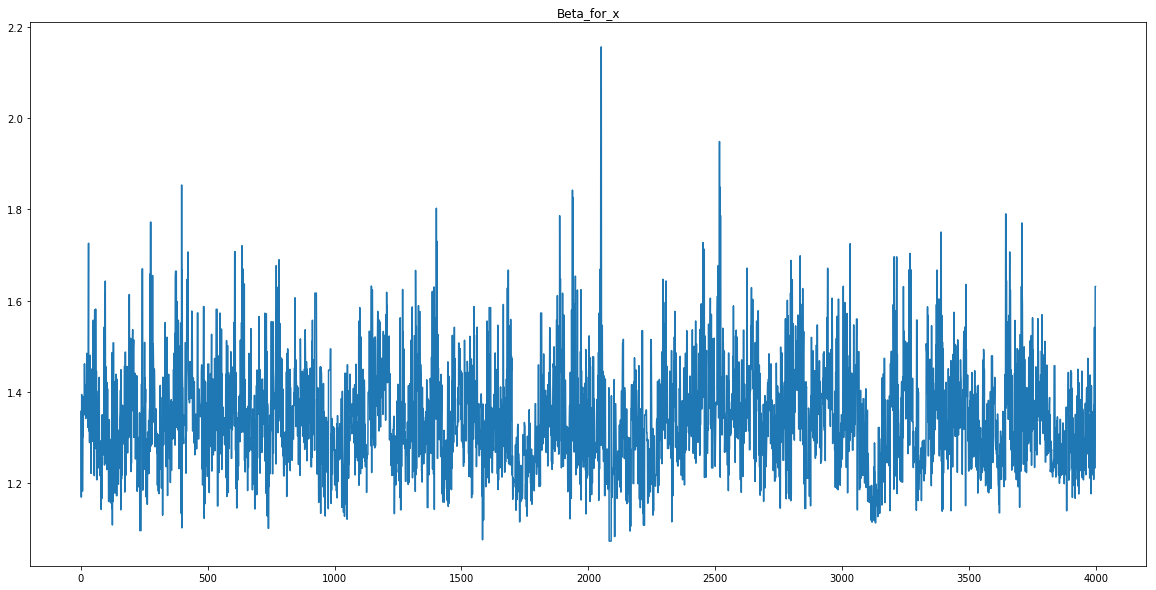

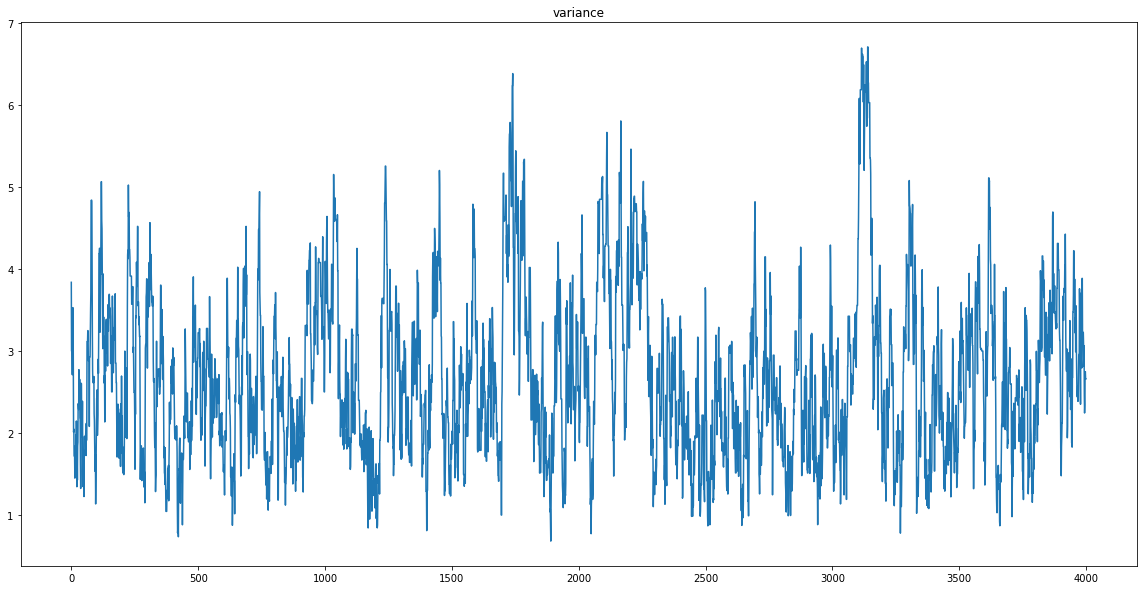

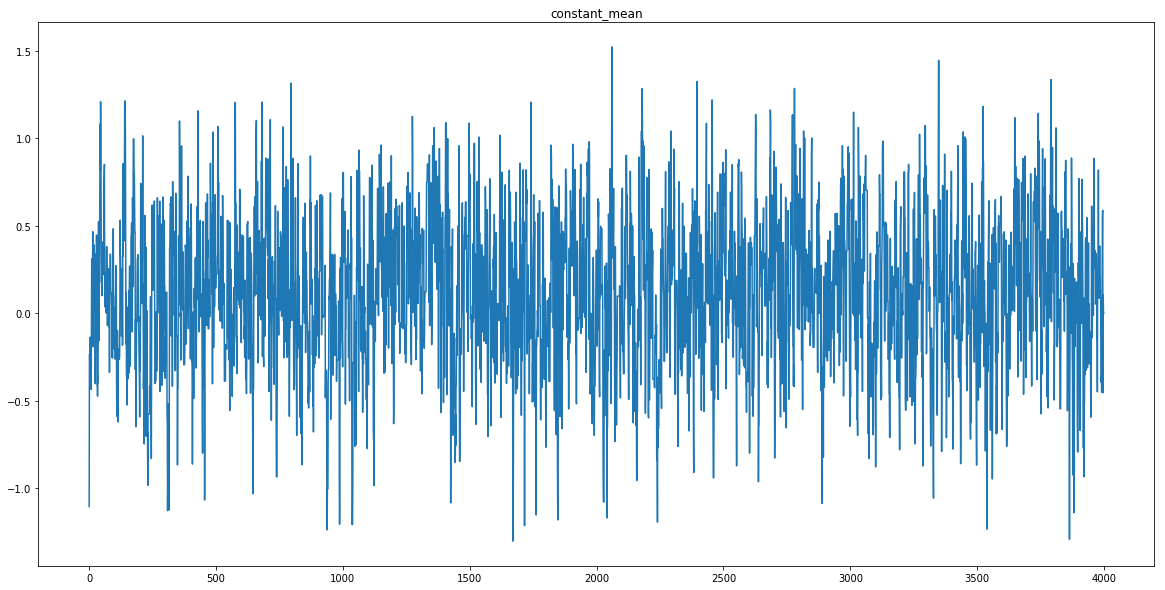

In [14]:
# Plotting  the chains for the inverse lengthscale 
t = np.arange(mcmc_samples)
for i in range(n_inputs):
    plt.figure(figsize = (20,10))
    plt.plot(t,beta_probs_[:,i])
    title = 'Beta_for_' +  labels[i]
    plt.title(title)

    
# Plotting the chains for the variances  
plt.figure(figsize = (20,10))
plt.plot(t,varm_probs_)
title = 'variance'
plt.title(title)




# Plotting the chains for the constant mean function
plt.figure(figsize = (20,10))
plt.plot(t,loc_probs_[:])
title = 'constant_mean'
plt.title(title)


In [15]:
print(loc_probs_.shape)
print(varm_probs_.shape)
print(beta_probs_.shape)

(4000,)
(4000,)
(4000, 1)


In [16]:
hyperpar_samples = [loc_probs_, varm_probs_, beta_probs_]

In [17]:
# Generating prediction for test data
mean_pos, var_pos, samples = model.samples(inputsnorm, hyperpar_samples, num_samples = 20, with_point_samples = True)
mean_test, var_test, samples_test = model.samples(test_inputsnorm , hyperpar_samples, num_samples = 20, with_point_samples = True)


In [18]:
print(mean_pos.shape)
print(var_pos.shape)
print(samples.shape)

print(mean_test.shape)
print(var_test.shape)
print(samples_test.shape)

(90,)
(90,)
(80000, 90)
(7,)
(7,)
(80000, 7)


In [19]:
std_pos = np.sqrt(var_pos)
std_test = np.sqrt(var_test)

In [20]:
# Converting to the right scale
mean_posf = mean_pos*std + mean 
std_posf = std_pos*std 
samplesf = samples*std + mean

mean_testf = mean_test*std + mean 
std_testf = std_test*std 
samples_testf = samples_test*std + mean

In [21]:
lower = np.percentile(samplesf,2.5, axis = 0)
upper = np.percentile(samplesf,97.5, axis = 0)

lower_test = np.percentile(samples_testf,2.5, axis = 0)
upper_test = np.percentile(samples_testf,97.5, axis = 0)

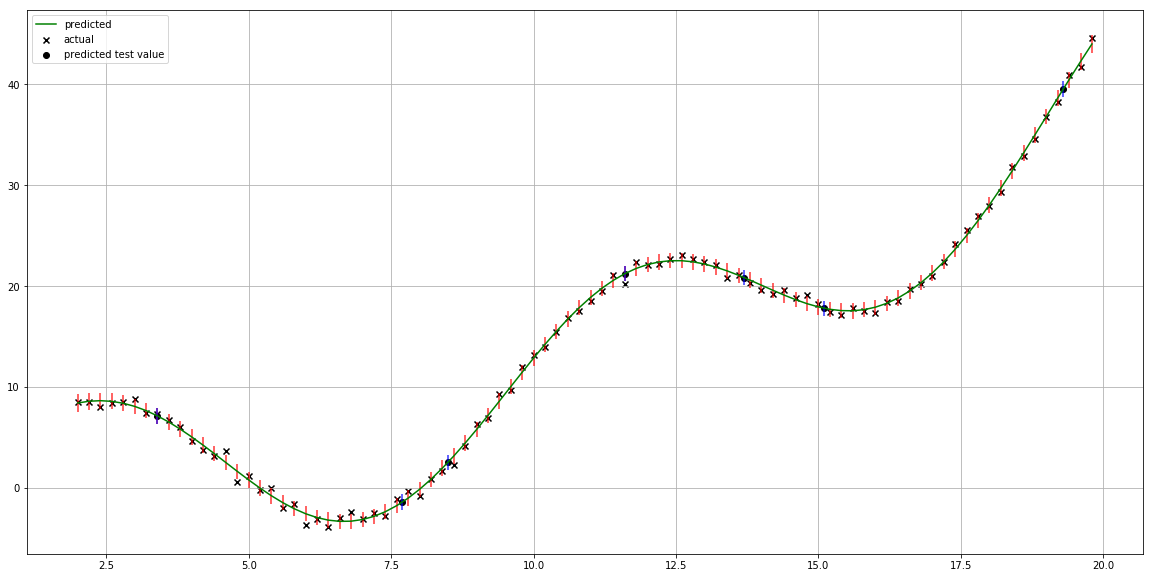

In [22]:
plt.figure(figsize =(20,10))
plt.scatter(inputs,outputs,marker='x', color = 'black', label = 'actual')
plt.plot(inputs, mean_posf, color = 'green', label = 'predicted')
plt.vlines(inputs, lower, upper, color = 'red', alpha = 0.8)

plt.scatter(test_inputs,mean_testf,marker='o', color = 'black', label = 'predicted test value')
plt.vlines(test_inputs, lower_test, upper_test, color = 'blue', alpha = 0.8)
plt.grid()
plt.legend()

   